## Feature selection

Random forests is one the most popular machine learning algorithms. It is so successful because it provide good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.

Random forests consist typically of 4-12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or a combination of features. At each node (that is, at each question), the three divides the dataset in 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is.

For classification, the measure of impurity is either Gini or the entropy. For regression the measure of impurity is the variance. When training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease elicited by each feature is averaged across trees to determine the final importance of the variable.

In general, features that are selected at the top of the trees are more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

Note

Random Forests and decision trees in general give preference to features with high cardinality
Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.
I will demonstrate how to select features based on tree importance using a regression and classification datase

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [27]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [29]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [30]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [31]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [32]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [33]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((425, 23), (183, 23))

In [34]:
# we fit Random Forests and select features in 2 lines of code

# first I specify the Random Forest instance and its parameters

# Then I use the selectFromModel class from sklearn
# to automatically select the features

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=42))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=42))

In [35]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel_.get_support()

array([False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True])

In [36]:
# let's make a list and count the selected features

selected_feat = X_train.columns[(sel_.get_support())]

len(selected_feat)

6

In [37]:
selected_feat

Index(['MMSE0m', 'HipsEntropybaseline', 'ERCsClusterShadebaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

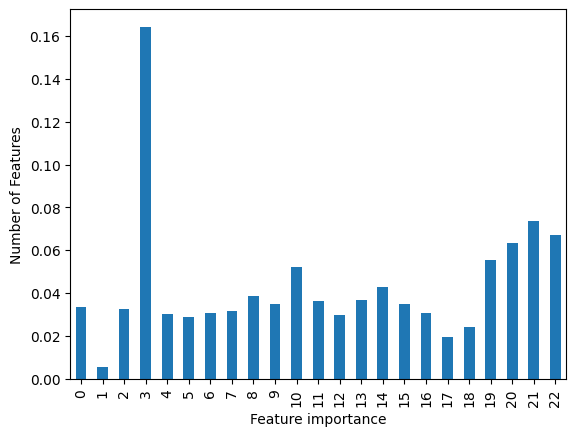

In [38]:
# and now let's plot the distribution of importances

pd.Series(sel_.estimator_.feature_importances_.ravel()).plot(kind="bar")
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [39]:
X_train_t = pd.DataFrame(sel_.transform(X_train))
X_test_t = pd.DataFrame(sel_.transform(X_test))

# add the columns name
X_train_t.columns = X_train.columns[(sel_.get_support())]
X_test_t.columns = X_train.columns[(sel_.get_support())]

X_train_t.shape, X_test_t.shape

((425, 6), (183, 6))

## Classification Test

In [40]:
def run_model(classifier_name, X_train, y_train):

        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False) 

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "RF",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [41]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

In [46]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Fit Time", "Total Features", "Metric"])
validation_df_report

Mean Train  \
Feature Selection Classifier    Fit Time Total Features Metric                          
RF                Random Forest 0.317    23             balanced_accuracy       0.891   
                                0.398    6              balanced_accuracy       0.832   
                  XGBoost       0.818    23             balanced_accuracy       1.000   
                                0.297    6              balanced_accuracy       1.000   
                  NGBoost       2.072    23             balanced_accuracy       0.697   
                                1.549    6              balanced_accuracy       0.652   

                                                                           Std Train  \
Feature Selection Classifier    Fit Time Total Features Metric                         
RF                Random Forest 0.317    23             balanced_accuracy      0.010   
                                0.398    6              balanced_accuracy      0.010   
                  XGBoost       0.818    23             balanced_accuracy      0.000   
                                0.297    6              balanced_accuracy      0.000   
                  NGBoost       2.072    23             balanced_accuracy      0.020   
                                1.549    6              balanced_accuracy      0.015   

                                                                           Mean Test  \
Feature Selection Classifier    Fit Time Total Features Metric                         
RF                Random Forest 0.317    23             balanced_accuracy      0.575   
                                0.398    6              balanced_accuracy      0.562   
                  XGBoost       0.818    23             balanced_accuracy      0.556   
                                0.297    6              balanced_accuracy      0.563   
                  NGBoost       2.072    23             balanced_accuracy      0.546   
                                1.549    6              balanced_accuracy      0.523   

                                                                           Std Test  
Feature Selection Classifier    Fit Time Total Features Metric                       
RF                Random Forest 0.317    23             balanced_accuracy     0.062  
                                0.398    6              balanced_accuracy     0.064  
                  XGBoost       0.818    23             balanced_accuracy     0.050  
                                0.297    6              balanced_accuracy     0.098  
                  NGBoost       2.072    23             balanced_accuracy     0.054  
                                1.549    6              balanced_accuracy     0.059

In [43]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "RF",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [44]:
pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)

In [45]:
prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t])
prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                             
RF                Random Forest 0.146               23             accuracy                   0.875   
                                                                   balanced_accuracy          0.881   
                                                                   precision                  0.880   
                                                                   recall                     0.875   
                                                                   f1_weighted                0.872   
                                                                   roc_auc_ovr_weighted       0.979   
                                0.153               6              accuracy                   0.802   
                                                                   balanced_accuracy          0.811   
                                                                   precision                  0.814   
                                                                   recall                     0.802   
                                                                   f1_weighted                0.799   
                                                                   roc_auc_ovr_weighted       0.966   
                  XGBoost       0.133               23             accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                                0.083               6              accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                  NGBoost       0.840               23             accuracy                   0.758   
                                                                   balanced_accuracy          0.675   
                                                                   precision                  0.745   
                                                                   recall                     0.758   
                                                                   f1_weighted                0.732   
                                                                   roc_auc_ovr_weighted       0.949   
                                0.465               6              accuracy                   0.739   
                                                                   balanced_accuracy          0.649   
                                                                   precision                  0.749   
                                                                   recall                     0.739   
                                                                   f1_weighted                0.703   
                                                                   roc_auc_ovr_weighted       0.932   

                                                                                         Test data  
Feature Selection Classifier    Classification Time Total Features Metric